In [62]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data, create_feature_df
from generate_anomalies import generate_single_anomaly, generate_short_term_anomaly, generate_long_term_anomaly
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import gc
from tqdm import tqdm_notebook
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [63]:
df_real = pd.read_csv('/mnt/HARD/Diplom/MinMax/results/ee_real.csv')
df_gen = pd.read_csv('/mnt/HARD/Diplom/MinMax/results/ee_gen.csv')

df_real['date_time_utc'] = pd.to_datetime(df_real['date_time_utc'])
df_gen['date_time_utc'] = pd.to_datetime(df_gen['date_time_utc'])

detectors = [col.split('_', 2)[-1] for col in df_real.columns if col.startswith('decision_function_')]

## Linear Transformation 

In [24]:
scaler = MinMaxScaler()
for detector in detectors:
    scl = copy(scaler)
    gen = df_gen['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    real = df_real['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    #f_gen['decision_function_lt_{0}'.format(detector)] = scl.fit_transform(gen)
    #f_real['decision_function_lt_{0}'.format(detector)] = scl.transform(real)
    df_gen['decision_function_lt_{0}'.format(detector)] = gen
    df_real['decision_function_lt_{0}'.format(detector)] = real
    
lt_cols = [col for col in df_gen if col.startswith('decision_function_lt_')]
df_gen['decision_function_lt'] = scaler.fit_transform(df_gen[lt_cols].sum(1).values.reshape(-1, 1))
df_real['decision_function_lt'] = scaler.transform(df_real[lt_cols].sum(1).values.reshape(-1, 1))
#df_gen['decision_function_lt'] = df_gen[lt_cols].sum(1) / len(detectors)
#df_real['decision_function_lt'] = df_real[lt_cols].sum(1) / len(detectors)

In [26]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]
results = []

for thresh in np.arange(0.1, 0.25, 0.01):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function_lt'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function_lt'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
#results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ee_fb_lt.csv', index=False)

threshold: 0.10 	 f1_gen: 0.859 	 f1_real: 0.244
threshold: 0.11 	 f1_gen: 0.898 	 f1_real: 0.339
threshold: 0.12 	 f1_gen: 0.924 	 f1_real: 0.434
threshold: 0.13 	 f1_gen: 0.943 	 f1_real: 0.529
threshold: 0.14 	 f1_gen: 0.952 	 f1_real: 0.596
threshold: 0.15 	 f1_gen: 0.958 	 f1_real: 0.632
threshold: 0.16 	 f1_gen: 0.960 	 f1_real: 0.672
threshold: 0.17 	 f1_gen: 0.963 	 f1_real: 0.697
threshold: 0.18 	 f1_gen: 0.965 	 f1_real: 0.714
threshold: 0.19 	 f1_gen: 0.962 	 f1_real: 0.695
threshold: 0.20 	 f1_gen: 0.958 	 f1_real: 0.700
threshold: 0.21 	 f1_gen: 0.955 	 f1_real: 0.683
threshold: 0.22 	 f1_gen: 0.952 	 f1_real: 0.672
threshold: 0.23 	 f1_gen: 0.948 	 f1_real: 0.618
threshold: 0.24 	 f1_gen: 0.941 	 f1_real: 0.603


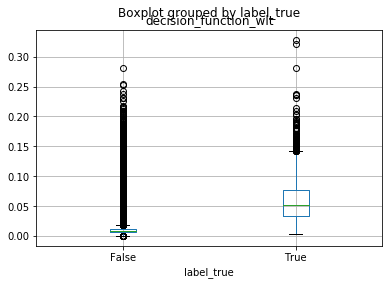

In [29]:
df_gen[df_gen['decision_function_lt'] < 10].boxplot('decision_function_lt', 'label_true')

## Weigted Linear Trasformation

In [28]:
scaler = MinMaxScaler()

for detector in detectors:
    scl = copy(scaler)
    gen = df_gen['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    real = df_real['decision_function_{0}'.format(detector)].values.reshape(-1, 1)
    #df_gen['decision_function_lt_{0}'.format(detector)] = scl.fit_transform(gen)
    #df_real['decision_function_lt_{0}'.format(detector)] = scl.transform(real)
    df_gen['decision_function_lt_{0}'.format(detector)] = gen
    df_real['decision_function_lt_{0}'.format(detector)] = real
    

corr_columns = [col for col in df_gen.columns if col.startswith('decision_function_lt_') or col=='label_true']
corr = df_gen[corr_columns].corr()['label_true']

for detector in detectors:
    weight = corr['decision_function_lt_{0}'.format(detector)]
    df_gen['decision_function_wlt_{0}'.format(detector)] = df_gen['decision_function_lt_{0}'.format(detector)] * weight
    df_real['decision_function_wlt_{0}'.format(detector)] = df_real['decision_function_lt_{0}'.format(detector)] * weight

wlt_cols = [col for col in df_gen if col.startswith('decision_function_wlt_')]
df_gen['decision_function_wlt'] = scaler.fit_transform(df_gen[lt_cols].sum(1).values.reshape(-1, 1))
df_real['decision_function_wlt'] = scaler.fit_transform(df_real[lt_cols].sum(1).values.reshape(-1, 1))

df_gen['decision_function_wlt'] = df_gen['decision_function_wlt'] / (corr.sum() - 1)
df_real['decision_function_wlt'] = df_real['decision_function_wlt'] / (corr.sum() - 1)

In [31]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]
results = []

for thresh in np.arange(0.04, 0.10, 0.002):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function_wlt'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function_wlt'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
#results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ee_fb_wlt.csv', index=False)

threshold: 0.04 	 f1_gen: 0.929 	 f1_real: 0.420
threshold: 0.04 	 f1_gen: 0.940 	 f1_real: 0.480
threshold: 0.04 	 f1_gen: 0.947 	 f1_real: 0.531
threshold: 0.05 	 f1_gen: 0.952 	 f1_real: 0.575
threshold: 0.05 	 f1_gen: 0.956 	 f1_real: 0.610
threshold: 0.05 	 f1_gen: 0.959 	 f1_real: 0.627
threshold: 0.05 	 f1_gen: 0.960 	 f1_real: 0.658
threshold: 0.05 	 f1_gen: 0.960 	 f1_real: 0.672
threshold: 0.06 	 f1_gen: 0.963 	 f1_real: 0.691
threshold: 0.06 	 f1_gen: 0.964 	 f1_real: 0.702
threshold: 0.06 	 f1_gen: 0.964 	 f1_real: 0.712
threshold: 0.06 	 f1_gen: 0.963 	 f1_real: 0.708
threshold: 0.06 	 f1_gen: 0.960 	 f1_real: 0.696
threshold: 0.07 	 f1_gen: 0.957 	 f1_real: 0.699
threshold: 0.07 	 f1_gen: 0.955 	 f1_real: 0.682
threshold: 0.07 	 f1_gen: 0.954 	 f1_real: 0.677
threshold: 0.07 	 f1_gen: 0.953 	 f1_real: 0.689
threshold: 0.07 	 f1_gen: 0.949 	 f1_real: 0.672
threshold: 0.08 	 f1_gen: 0.948 	 f1_real: 0.631
threshold: 0.08 	 f1_gen: 0.943 	 f1_real: 0.613
threshold: 0.08 	 f1

In [32]:
df_gen[df_gen['decision_function_wlt'] < 10].boxplot('decision_function_wlt', 'label_true')

## Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for detector in detectors:
    df_gen['decision_function_log_{0}'.format(detector)] = df_gen['decision_function_{0}'.format(detector)]
    df_real['decision_function_log_{0}'.format(detector)] = df_real['decision_function_{0}'.format(detector)]

log_cols = [col for col in df_gen if col.startswith('decision_function_log_')]

X_train = df_gen[log_cols]
y_train = df_gen['label_true']

X_test = df_real[log_cols]
y_test = df_real['label_true']

clf = LogisticRegression(C=100)
clf.fit(X_train, y_train)

df_gen['decision_function_log'] = clf.decision_function(X_train)
df_real['decision_function_log'] = clf.decision_function(X_test)

df_gen['decision_function_log'] = scaler.fit_transform(df_gen['decision_function_log'].values.reshape(-1, 1))
df_real['decision_function_log'] = scaler.transform(df_real['decision_function_log'].values.reshape(-1, 1))

In [68]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]
results = []

for thresh in np.arange(0.2, 0.32, 0.005):
#for thresh in np.arange(0.2, 0.25, 0.01):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function_log'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function_log'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.4f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
#results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ee_fb_log.csv', index=False)

threshold: 0.20 	 f1_gen: 0.9542 	 f1_real: 0.411
threshold: 0.21 	 f1_gen: 0.9597 	 f1_real: 0.494
threshold: 0.21 	 f1_gen: 0.9634 	 f1_real: 0.562
threshold: 0.22 	 f1_gen: 0.9651 	 f1_real: 0.617
threshold: 0.22 	 f1_gen: 0.9651 	 f1_real: 0.670
threshold: 0.23 	 f1_gen: 0.9634 	 f1_real: 0.672
threshold: 0.23 	 f1_gen: 0.9610 	 f1_real: 0.708
threshold: 0.24 	 f1_gen: 0.9574 	 f1_real: 0.713
threshold: 0.24 	 f1_gen: 0.9541 	 f1_real: 0.706
threshold: 0.25 	 f1_gen: 0.9489 	 f1_real: 0.699
threshold: 0.25 	 f1_gen: 0.9408 	 f1_real: 0.660
threshold: 0.26 	 f1_gen: 0.9318 	 f1_real: 0.668
threshold: 0.26 	 f1_gen: 0.9224 	 f1_real: 0.663
threshold: 0.27 	 f1_gen: 0.9134 	 f1_real: 0.636
threshold: 0.27 	 f1_gen: 0.8962 	 f1_real: 0.633
threshold: 0.28 	 f1_gen: 0.8819 	 f1_real: 0.626
threshold: 0.28 	 f1_gen: 0.8622 	 f1_real: 0.615
threshold: 0.29 	 f1_gen: 0.8456 	 f1_real: 0.613
threshold: 0.29 	 f1_gen: 0.8307 	 f1_real: 0.615
threshold: 0.30 	 f1_gen: 0.8105 	 f1_real: 0.616


In [69]:
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ee_fb_log.csv', index=False)

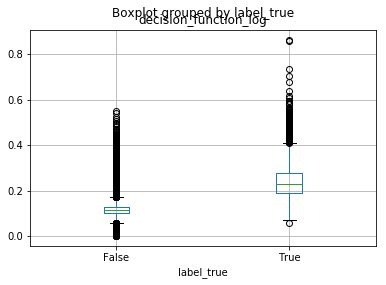

In [58]:
df_gen[df_gen['decision_function_log'] < 1.0].boxplot('decision_function_log', 'label_true')